# Model Formulation

This notebook can be used to run initial model with DCOPF and a basic budget variable. Before running this nodebook please refer to `Test-System-Data-Processing.ipynb` to preprocess generator, lines, buses, and loads data. 

In [1]:
using JuMP, Gurobi
using DataFrames, CSV

In [317]:
# Global path to test system datasets
PATH = joinpath(pwd(), "..", "data", "test_system") 

# Load each of the San Diego test system files 
gens = CSV.read(joinpath(PATH, "gens.csv"), DataFrame);
lines = CSV.read(joinpath(PATH, "lines.csv"), DataFrame);
buses = CSV.read(joinpath(PATH, "buses.csv"), DataFrame);
loads = CSV.read(joinpath(PATH, "loads_24h_su.csv"), DataFrame);

# Add load to bus dataset equal to first hour of load
buses[:, :pd] = loads[:, 16];
println("Consistent buses: ", all(buses[:, :bus] .== loads[:, :bus]))

Consistent buses: true


In [362]:
function initialize_model(gens, lines, buses, demand)
    """
    Function to solve DC OPF problem 
    Inputs:
        gens -- dataframe with generator info and costs
        lines -- dataframe with transmission lines info
        buses -- dataframe with bus types and loads
    """   
        
    function line(i, j, col)
        return lines[lines_map[(i, j)], col]
    end
    
    function J(i)
        return tbus[fbus .== i]
    end
    
    fbus = lines[!,:f_bus] # All from buses
    tbus = lines[!,:t_bus] # All to buses 
    
    # Sets
    G = 1:nrow(gens)             # G: Set of all generators
    N = 1:nrow(buses)            # N: Set of all network nodes
    L = collect(zip(fbus, tbus)) # L: Set of all lines/branches
    T = 1:ncol(demand)           # T: Set of all hours
    
    lines_map = Dict(zip(L, 1:length(L)))
    
    # Parameters
    θlim = π*(60/180)  # Absolute max angle limit in rad
    slack_bus = 416    # Set slack bus to one with many CTs
    shed_cost = 1000   # Cost of load sheding
    
    # Toy parameters for a limited investment in solar at each bus
    budget = 0
    solar_cost = 0.1475
    
    # Model
    DCOPF = Model(() -> Gurobi.Optimizer())
    set_optimizer_attribute(DCOPF, "NumericFocus", 2)
    
    # Decision variables   
    @variables(DCOPF, begin
        GEN[G,T]          # Generation of each generator 
        SHED[N,T] ≥ 0     # Load sheading at bus N
        THETA[N,T]        # Voltage phase angle of bus
        FLOW[L,T]         # Flows between all pairs of nodes
    end)
    
    @constraint(DCOPF, cShed[i ∈ N, t ∈ T], SHED[i,t] ≤ demand[i,t])
    
    # Objective function (Note: Using just the linear part of quadratic cost)
    @objective(DCOPF, Min,
            sum(gens[g,:c1] * GEN[g,t] for g ∈ G, t ∈ T) 
            + sum(shed_cost * SHED[i,t] for i ∈ N, t ∈ T) #TODO expressions
    ) 
    
    # Supply demand balances: sum(generation) + shedding - demand - 0.5*sum(losses) = sum(flows)
    @constraint(DCOPF, cBalance[i ∈ N, t ∈ T], 
        sum(GEN[g,t] for g ∈ G[gens.bus .== i])
        - demand[i,t] + SHED[i,t]
         == sum(FLOW[(i,j),t] for j ∈ J(i))
    )
    
    # Max and min generation constraints
    @constraint(DCOPF, cMaxGen[g ∈ G, t ∈ T], GEN[g,t] ≤ gens[g,:pmax]) ## TODO add capacity factors
    @constraint(DCOPF, cMinGen[g ∈ G, t ∈ T], GEN[g,t] ≥ gens[g,:pmin])
    
    
    #### DC OPF ####
    
    # Create slack bus with theta=0
    fix.(THETA[slack_bus, T], 0)
    
    # Max line flow constraints
    @constraint(DCOPF, cLineLimits[(i,j) ∈ L, t ∈ T], 
        FLOW[(i,j),t] ≤ line(i,j,:rate_a)) 
    
    # Angle limits 
    @constraint(DCOPF, cAngleLimitsMax[(i,j) ∈ L, t ∈ T], 
        (THETA[i,t] - THETA[j,t]) ≤  θlim)
    @constraint(DCOPF, cAngleLimitsMin[(i,j) ∈ L, t ∈ T], 
        (THETA[i,t] - THETA[j,t]) ≥ -θlim)
                    
    # Flow constraints on each branch
    @constraint(DCOPF, cLineFlows[(i,j) ∈ L, t ∈ T],
        FLOW[(i,j),t] == line(i,j,:sus)*(THETA[i,t] - THETA[j,t]));
    
    return DCOPF
end

initialize_model (generic function with 2 methods)

In [367]:
dcopf = initialize_model(gens, lines, buses, loads[:, 2:25])

Set parameter Username
Set parameter LicenseID to value 2669913
Academic license - for non-commercial use only - expires 2026-05-22
Set parameter NumericFocus to value 2


A JuMP Model
├ solver: Gurobi
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 56016
├ num_constraints: 158496
│ ├ AffExpr in MOI.EqualTo{Float64}: 40824
│ ├ AffExpr in MOI.GreaterThan{Float64}: 32544
│ ├ AffExpr in MOI.LessThan{Float64}: 73368
│ ├ VariableRef in MOI.EqualTo{Float64}: 24
│ └ VariableRef in MOI.GreaterThan{Float64}: 11736
└ Names registered in the model
  └ :FLOW, :GEN, :SHED, :THETA, :cAngleLimitsMax, :cAngleLimitsMin, :cBalance, :cLineFlows, :cLineLimits, :cMaxGen, :cMinGen, :cShed

In [369]:
optimize!(dcopf)

Set parameter NumericFocus to value 2
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M2 Ultra
Thread count: 24 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
NumericFocus  2

Optimize a model with 146736 rows, 56016 columns and 295632 nonzeros
Model fingerprint: 0x94d651a6
Coefficient statistics:
  Matrix range     [1e+00, 1e+07]
  Objective range  [7e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+03]
Presolve removed 126104 rows and 34904 columns
Presolve time: 0.11s
Presolved: 20632 rows, 25288 columns, 89816 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.924e+05
 Factor NZ  : 4.621e+05 (roughly 22 MB of memory)
 Factor Ops : 1.235e+07 (less than 1 second per iteration)
 Threads    : 22

                  Objective                R

In [239]:
# Get generation by type
gdf = groupby(innerjoin(gens, solution.generation, on = :id), :fueltype)
df = combine(gdf, :gen => sum)
df[:, :max_gen] .= combine(groupby(gens, :fueltype), :pmax => sum)[:, :pmax_sum]
df

Row,fueltype,gen_sum,max_gen
,String,Float64,Float64
1,Conventional Hydroelectric,1.5,8.9
2,Other Waste Biomass,0.0,12.3
3,Natural Gas Fired Combustion Turbine,589.876,1656.3
4,Petroleum Liquids,0.0,4.5
5,Landfill Gas,0.0,17.0
6,Natural Gas Fired Combined Cycle,998.0,1346.2
7,Solar Photovoltaic,684.085,684.085
8,Natural Gas Internal Combustion Engine,3.6,3.6
9,Onshore Wind Turbine,186.018,194.0


In [383]:
[sum(value.(dcopf[:SHED]).data[:, i]) / sum(loads[:, i]) for i in 1:24]

# Doubling line capacity can reduce load shed to 14% from 23% --> TODO: there are still large loads?
# 0.3581212101997119 <old dcopf
# 0.3558440727764083 <1/x

24-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [161]:


#CSV.write("shed.csv", solution.shedding)

sum(buses[:, :pd])

2471.162

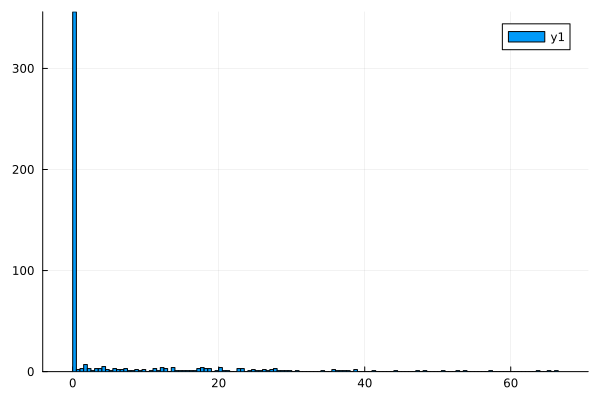

In [347]:
using Plots

histogram(buses[:, :pd])

initialize_model (generic function with 1 method)

Set parameter Username
Set parameter LicenseID to value 2669913
Academic license - for non-commercial use only - expires 2026-05-22
Set parameter NumericFocus to value 2


In [213]:
lines[lines[:, :t_bus] .== 130, :]

Row,f_bus,t_bus,r,x,b,rate_a,sus
,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,358,130,0.000764857,0.00297549,0.000383252,3.18,315.249
2,19,130,0.000138186,0.000320762,4.71258e-5,1.18,2000.0
3,19,130,0.000127913,0.000321538,4.0171e-5,1.18,2000.0


In [287]:
sum(lines[:, :x] .< 1e-4) # 0.001

54

In [181]:
# Model
model = Model(() -> Gurobi.Optimizer())
set_optimizer_attribute(DCOPF, "NumericFocus", 2)

# Decision variables   
@variables(model, begin
    FLOW[L]       # Flows between all pairs of nodes
end)

@constraint(model, cLineFlows[(i, j) ∈ L],
            FLOW[(i, j)] <= 1)

Set parameter Username
Set parameter LicenseID to value 2669913
Academic license - for non-commercial use only - expires 2026-05-22
Set parameter NumericFocus to value 2


1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, [(1, 3), (2, 4)]
And data, a 2-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape}}:
 cLineFlows[(1, 3)] : FLOW[(1, 3)] ≤ 1
 cLineFlows[(2, 4)] : FLOW[(2, 4)] ≤ 1

In [173]:
L = collect(zip([1, 2],[3, 4]))

2-element Vector{Tuple{Int64, Int64}}:
 (1, 3)
 (2, 4)

In [333]:
function model_outputs(model, gens, lines, buses)

    N = 1:nrow(buses)      # N: Set of all network nodes
    fbus = lines[!,:f_bus] # All from buses
    tbus = lines[!,:t_bus] # All to buses
    baseMVA = 100
    
    generation = DataFrame(
        id = gens.id,
        node = gens.bus,
        gen = value.(model[:GEN]).data
        )
    
    # Angles of each bus
    #angles = value.(model[:THETA]).data
    
    flows = DataFrame(
        fbus = fbus,
        tbus = tbus,
        #flow = value.(model[:FLOW]).data #baseMVA .* lines.sus .* (angles[fbus] .- angles[tbus])
    )
    
    prices = DataFrame(
        node = N,
        value = dual.(model[:cBalance]).data
    )
    # Amound of load shed at each bus
    shedding = DataFrame(
        node = N,
        shed =value.(model[:SHED]).data
    )
    
    return (
        generation = generation, 
        #angles,
        flows,
        prices,
        shedding,
        cost = objective_value(model),
        status = termination_status(model)
    )
end

LoadError: MethodError: no method matching ncol()
[0mClosest candidates are:
[0m  ncol([91m::Tables.MatrixRowTable[39m) at ~/.julia/packages/Tables/8p03y/src/matrix.jl:118
[0m  ncol([91m::Tables.AbstractColumns[39m) at ~/.julia/packages/Tables/8p03y/src/fallbacks.jl:283
[0m  ncol([91m::NamedTuple{names, T} where {N, names, T<:Tuple{Vararg{AbstractVector, N}}}[39m) at ~/.julia/packages/Tables/8p03y/src/namedtuples.jl:197
[0m  ...

Row,2018-08-12 00:00:00-05:00,2018-08-12 01:00:00-05:00,2018-08-12 02:00:00-05:00,2018-08-12 03:00:00-05:00,2018-08-12 04:00:00-05:00,2018-08-12 05:00:00-05:00,2018-08-12 06:00:00-05:00,2018-08-12 07:00:00-05:00,2018-08-12 08:00:00-05:00,2018-08-12 09:00:00-05:00,2018-08-12 10:00:00-05:00,2018-08-12 11:00:00-05:00,2018-08-12 12:00:00-05:00,2018-08-12 13:00:00-05:00,2018-08-12 14:00:00-05:00,2018-08-12 15:00:00-05:00,2018-08-12 16:00:00-05:00,2018-08-12 17:00:00-05:00,2018-08-12 18:00:00-05:00,2018-08-12 19:00:00-05:00,2018-08-12 20:00:00-05:00,2018-08-12 21:00:00-05:00,2018-08-12 22:00:00-05:00,2018-08-12 23:00:00-05:00
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,15.7014,14.4658,13.6155,13.1381,13.1089,13.8865,15.3513,16.3542,17.1494,16.9305,16.5762,16.9139,17.5557,18.9136,20.4511,22.1104,23.644,25.2563,26.2254,26.2471,25.5498,24.5912,22.2813,19.6175
2,7.1192,6.6493,6.3183,6.1328,6.1149,6.4104,7.0012,7.427,7.771,7.8272,7.8023,8.0074,8.3196,8.8665,9.4866,10.125,10.6799,11.2188,11.4781,11.3906,11.0624,10.6299,9.6931,8.6462
3,22.0957,19.861,18.3643,17.5224,17.5068,18.9151,21.3796,22.9495,24.1597,22.9973,21.7523,21.9421,22.7292,25.0181,27.605,30.5664,33.4965,36.8207,39.1744,39.7402,38.8249,37.4644,33.606,28.9735
4,17.9732,16.4937,15.4809,14.9121,14.882,15.8134,17.5432,18.712,19.6342,19.2713,18.7676,19.1167,19.8362,21.4402,23.2558,25.2375,27.0945,29.0788,30.3182,30.4135,29.6239,28.5251,25.8011,22.6357
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,8.4297,7.9038,7.5304,7.3213,7.2985,7.629,8.3037,8.7982,9.1999,9.319,9.3355,9.5959,9.9727,10.597,11.3052,12.0225,12.632,13.2052,13.4513,13.3147,12.922,12.4106,11.3388,10.1536
7,30.767,27.7611,25.7412,24.6052,24.578,26.472,29.8175,31.9697,33.6354,32.1992,30.625,30.9501,32.0709,35.1774,38.6892,42.679,46.5942,50.9977,54.0638,54.7374,53.4487,51.5568,46.314,40.0522
8,11.6008,10.7975,10.2356,9.9205,9.8932,10.3984,11.3916,12.0975,12.6649,12.6919,12.595,12.9076,13.4076,14.3273,15.3697,16.4572,17.4197,18.3777,18.8749,18.7728,18.2429,17.5372,15.9649,14.1922
9,2.1196,1.878,1.718,1.6279,1.6278,1.7801,2.0386,2.198,2.319,2.1607,2.0004,2.0029,2.072,2.3123,2.5837,2.9021,3.2255,3.6023,3.8823,3.966,3.8818,3.7506,3.3472,2.8543
